Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ historical_input    │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     10,800 │ historical_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forecast_input      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 52)        │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ forecast_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50)        │      2,650 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20)        │      1,020 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         21 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,491 (56.61 KB)

 Trainable params: 14,491 (56.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5424172.0000 - val_loss: 3362151.2500
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3706455.5000 - val_loss: 1594027.6250
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2051578.5000 - val_loss: 740365.1250
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1265628.5000 - val_loss: 510789.9062
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 809463.8125 - val_loss: 338286.8125
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 767425.7500 - val_loss: 491230.7500
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 933830.6250 - val_loss: 386918.6562
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 800621.6250 - val_loss: 486260.8125
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1057030.6250 - val_loss: 397396.6875
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 914251.6875 - val_loss: 392992.1875
Epoch 11/100
160/160 ━

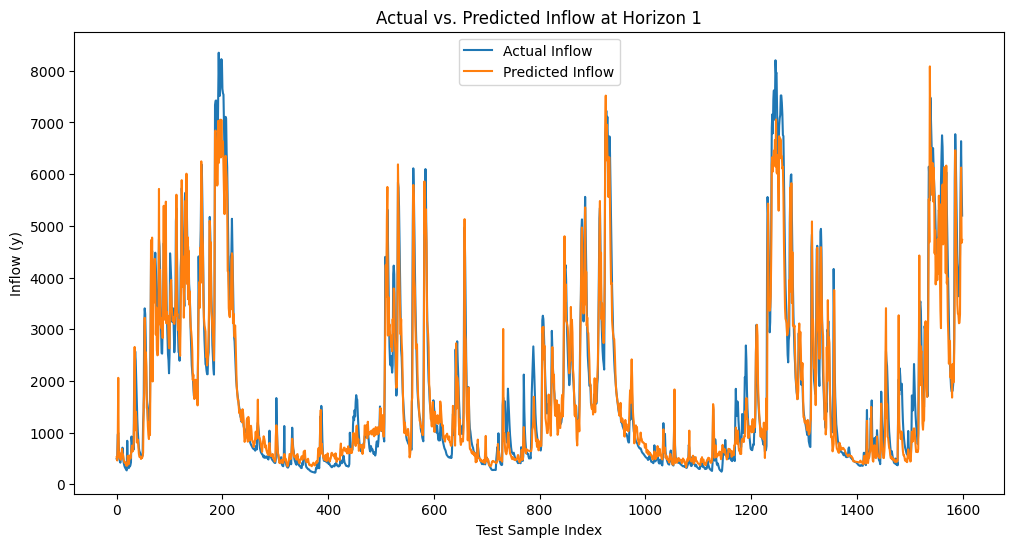

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 1. Data Loading and Preprocessing
# -------------------------------

# Adjust the data_path variable as needed.
data_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
df = pd.read_csv(data_path)

# Convert time column to datetime, sort by time and set as index.
df['t'] = pd.to_datetime(df['time'])
df = df.sort_values('t')
df.set_index('t', inplace=True)

# Rename inflow column 'KarupBro' to 'y'.
df['y'] = df['KarupBro']

# (Optional) Data cleaning:
temp_mask = df['temp_mean_daily'] > 35
df.loc[temp_mask, 'temp_mean_daily'] = df['temp_mean_daily'].shift(1)[temp_mask]
precip_mask = df['precip_total_daily'] > 100
df.loc[precip_mask, 'precip_total_daily'] = 0

# -------------------------------
# 2. Create Sequences for LSTM
# -------------------------------

def create_sequences(data, input_length):
    """
    Create input sequences and corresponding forecast features.
    
    Parameters:
        data: DataFrame with columns ['y', 'temp_mean_daily', 'precip_total_daily'].
        input_length: Number of past days to include in the historical input sequence.
        
    Returns:
        X_hist: NumPy array of shape (n_samples, input_length, 3)
                (features: [y, temp_mean_daily, precip_total_daily]).
        X_forecast: NumPy array of shape (n_samples, 2)
                    (forecast features for target day: [temp_mean_daily, precip_total_daily]).
        y: NumPy array of target inflow values for the forecast day.
    """
    X_hist, X_forecast, y = [], [], []
    # Start at index `input_length` so that we can get a full historical window.
    for i in range(input_length, len(data)):
        hist_seq = data.iloc[i - input_length:i][['y', 'temp_mean_daily', 'precip_total_daily']].values
        forecast_vec = data.iloc[i][['temp_mean_daily', 'precip_total_daily']].values
        target = data.iloc[i]['y']
        X_hist.append(hist_seq)
        X_forecast.append(forecast_vec)
        y.append(target)
    return np.array(X_hist), np.array(X_forecast), np.array(y)

# Choose the sequence length: 30, 90, or 365 days.
sequence_length = 30  # Change to 90 or 365 as desired.

X_hist, X_forecast, y_values = create_sequences(df, sequence_length)

# -------------------------------
# 3. Split into Training and Testing Sets
# -------------------------------
# Use the first 80% for training and the remaining 20% for testing (time-ordered split).
split_index = int(len(X_hist) * 0.8)
X_hist_train = X_hist[:split_index]
X_forecast_train = X_forecast[:split_index]
y_train = y_values[:split_index]

X_hist_test = X_hist[split_index:]
X_forecast_test = X_forecast[split_index:]
y_test = y_values[split_index:]

# Convert data types to float32 to ensure numeric inputs for Keras.
X_hist_train = X_hist_train.astype(np.float32)
X_forecast_train = X_forecast_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_hist_test = X_hist_test.astype(np.float32)
X_forecast_test = X_forecast_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# -------------------------------
# 4. Build the LSTM Forecasting Model
# -------------------------------

# Define two inputs.
# Historical input: shape (sequence_length, 3)
input_hist = Input(shape=(sequence_length, 3), name="historical_input")
# Process the historical sequence using an LSTM.
lstm_out = LSTM(50, activation='tanh')(input_hist)
lstm_out = Dropout(0.2)(lstm_out)

# Forecast input: weather for the forecast day (2 features: temp and precip)
input_forecast = Input(shape=(2,), name="forecast_input")

# Concatenate the outputs of both parts.
combined = Concatenate()([lstm_out, input_forecast])
dense_1 = Dense(50, activation='relu')(combined)
dense_2 = Dense(20, activation='relu')(dense_1)
output = Dense(1, name="output")(dense_2)

# Create and compile the model.
model = Model(inputs=[input_hist, input_forecast], outputs=output)
model.compile(optimizer=Adam(), loss='mse')
model.summary()

# -------------------------------
# 5. Train the Model
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit([X_hist_train, X_forecast_train], y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# -------------------------------
# 6. Evaluate the Model
# -------------------------------
# Predict on test set.
y_pred = model.predict([X_hist_test, X_forecast_test])
# Compute RMSE.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

# -------------------------------
# 7. Plot Actual vs. Predicted Values
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Inflow")
plt.plot(y_pred, label="Predicted Inflow")
plt.xlabel("Test Sample Index")
plt.ylabel("Inflow (y)")
plt.title("Actual vs. Predicted Inflow at Horizon 1")
plt.legend()
plt.show()


Trial 30 Complete [00h 01m 21s]
val_loss: 833184.9375

Best val_loss So Far: 497975.25
Total elapsed time: 01h 39m 08s
Best Hyperparameters Found:
{'lstm_units': 100, 'dropout_rate': 0.2, 'dense_units': 100, 'learning_rate': 0.0001}
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 15838140.0000 - mae: 1697.8911
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 15801597.0000 - mae: 1690.7655
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 15709040.0000 - mae: 1674.0618
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 15510495.0000 - mae: 1638.0079
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 15096504.0000 - mae: 1562.4487
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 14460139.0000 - mae: 1444.5465
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 13709860.0000 - mae: 1331.3973
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 12911106.0000 - mae: 1245.6727
Epoch 9/100
200/200 ━━━━━━━━━━━

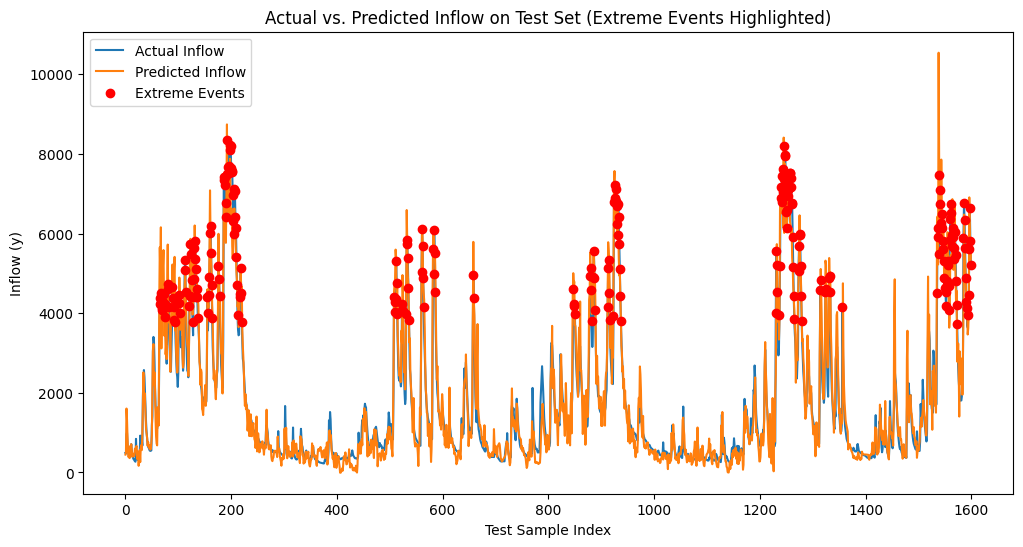

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import TimeSeriesSplit

# ----------------------------
# 1. Data Loading and Preprocessing
# ----------------------------

data_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
df = pd.read_csv(data_path)

df['t'] = pd.to_datetime(df['time'])
df = df.sort_values('t')
df.set_index('t', inplace=True)
df['y'] = df['KarupBro']

temp_mask = df['temp_mean_daily'] > 35
df.loc[temp_mask, 'temp_mean_daily'] = df['temp_mean_daily'].shift(1)[temp_mask]
precip_mask = df['precip_total_daily'] > 100
df.loc[precip_mask, 'precip_total_daily'] = 0

# ----------------------------
# 2. Create Sequences for LSTM
# ----------------------------

def create_sequences(data, input_length):
    X_hist, X_forecast, y_seq = [], [], []
    for i in range(input_length, len(data)):
        hist = data.iloc[i - input_length:i][['y', 'temp_mean_daily', 'precip_total_daily']].values
        forecast = data.iloc[i][['temp_mean_daily', 'precip_total_daily']].values
        target = data.iloc[i]['y']
        X_hist.append(hist)
        X_forecast.append(forecast)
        y_seq.append(target)
    return np.array(X_hist, dtype=np.float32), np.array(X_forecast, dtype=np.float32), np.array(y_seq, dtype=np.float32)

sequence_length = 30
X_hist, X_forecast, y_values = create_sequences(df, sequence_length)

# ----------------------------
# 3. Split Data: Train+Validation and Test
# ----------------------------
total_samples = len(X_hist)
train_val_end = int(total_samples * 0.8)
X_hist_train_val = X_hist[:train_val_end]
X_forecast_train_val = X_forecast[:train_val_end]
y_train_val = y_values[:train_val_end]

X_hist_test = X_hist[train_val_end:]
X_forecast_test = X_forecast[train_val_end:]
y_test = y_values[train_val_end:]

# ----------------------------
# 4. Sample Weighting for Extreme Events
# ----------------------------
extreme_threshold = np.percentile(y_train_val, 90)
extreme_weight = 3.0

def get_sample_weights(y_array):
    return np.where(y_array >= extreme_threshold, extreme_weight, 1.0)

sw_train_val = get_sample_weights(y_train_val)

# ----------------------------
# 5. Define Model Building Function for Bayesian Optimization
# ----------------------------

def build_model(hp):
    input_hist = Input(shape=(sequence_length, 3), name="historical_input")
    lstm_units = hp.Int('lstm_units', min_value=30, max_value=100, step=10)
    x = LSTM(lstm_units, activation='tanh')(input_hist)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)
    
    input_forecast = Input(shape=(2,), name="forecast_input")
    combined = Concatenate()([x, input_forecast])
    
    dense_units = hp.Int('dense_units', min_value=20, max_value=100, step=10)
    x = Dense(dense_units, activation='relu')(combined)
    x = Dense(dense_units // 2, activation='relu')(x)
    output = Dense(1, name="output")(x)
    
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model = Model(inputs=[input_hist, input_forecast], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# ----------------------------
# 6. Bayesian Optimization with Keras Tuner
# ----------------------------

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=30,
    directory='lstm_hydro_tuning_bayes',
    project_name='hydro_extremes'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Keras Tuner does not directly support time series CV, so we use a validation split that respects time order.
tuner.search([X_hist_train_val, X_forecast_train_val], y_train_val,
             sample_weight=sw_train_val,
             validation_split=0.2,
             epochs=50,
             batch_size=32,
             callbacks=[early_stop],
             shuffle=False)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters Found:")
print(best_hp.values)

# ----------------------------
# 7. Final Model Retraining and Evaluation
# ----------------------------

final_model = tuner.hypermodel.build(best_hp)
early_stop_final = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
final_model.fit([X_hist_train_val, X_forecast_train_val],
                y_train_val,
                sample_weight=sw_train_val,
                epochs=100,
                batch_size=32,
                callbacks=[early_stop_final],
                verbose=1,
                shuffle=False)

y_pred = final_model.predict([X_hist_test, X_forecast_test])
overall_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nTest RMSE (Overall):", overall_rmse)

extreme_mask_test = y_test >= extreme_threshold
if np.sum(extreme_mask_test) > 0:
    extreme_rmse = np.sqrt(mean_squared_error(y_test[extreme_mask_test], y_pred[extreme_mask_test]))
    print("Test RMSE (Extreme Events):", extreme_rmse)
else:
    print("No extreme events found in test set.")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Inflow")
plt.plot(y_pred, label="Predicted Inflow")
plt.scatter(np.where(extreme_mask_test)[0], y_test[extreme_mask_test], color='red', label="Extreme Events", zorder=5)
plt.xlabel("Test Sample Index")
plt.ylabel("Inflow (y)")
plt.title("Actual vs. Predicted Inflow on Test Set (Extreme Events Highlighted)")
plt.legend()
plt.show()